In [2]:
from collections import Counter
import numpy as np

In [3]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [4]:
class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [5]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [6]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [7]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]

In [8]:
class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_feats=self.n_feats,
            )
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [9]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy*100

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [52]:
data = datasets.load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=123)

In [13]:
RandomForest_acc = []

In [53]:
clf = RandomForest(n_trees=3, max_depth=10)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)
RandomForest_acc.append(acc)

print("Accuracy of Random forest is:", acc)

Accuracy of Random forest is: 85.92592592592592


In [15]:
class NaiveBayes:

  def fit(self, X, y):
    n_samples , n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)

    self._mean = np.zeros((n_classes,n_features), dtype=np.float64)
    self._var = np.zeros((n_classes,n_features), dtype=np.float64)
    self._priors = np.zeros(n_classes, dtype=np.float64)

    for idx, c in enumerate(self._classes):
      X_c = X[y==c]
      self._mean[idx, :] = X_c.mean(axis=0)
      self._var[idx, :] = X_c.var(axis=0)
      self._priors[idx] = X_c.shape[0]/float(n_samples)

  def predict(self,X):
    y_pred = [self._predict(x) for x in X]
    return np.array(y_pred)
  
  def _predict(self, x):
    posteriors = []

    for idx, c in enumerate(self._classes):
      prior = np.log(self._priors[idx])
      posterior = np.sum(np.log(self._pdf(idx,x)))
      posterior = prior + posterior
      posteriors.append(posterior)

    return self._classes[np.argmax(posteriors)]

  def _pdf(self, class_idx, x):
    mean = self._mean[class_idx]
    var = self._var[class_idx]
    numerator = np.exp(- (x-mean)**2 / (2 * var))
    denominator = np.sqrt(2 * np.pi * var)
    return numerator / denominator
  


In [16]:
NaiveBayes_acc = []

In [54]:
nb = NaiveBayes()
nb.fit(X_train,y_train)
predictions = nb.predict(X_test)
NaiveBayes_acc.append(accuracy(y_test,predictions))

print('Naive Bayes accuracy on iris:', accuracy(y_test,predictions))

Naive Bayes accuracy on iris: 88.88888888888889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


In [21]:
class KNN:
  def __init__(self, X, y, k):
    self.X_train = X
    self.y_train = y 
    self.k = k

  def euclidean_distance(self, inst1, inst2):
    distance = np.linalg.norm(inst1-inst2)
    return distance
  
  def _get_k_neighbors(self, inst1):
    distances = []
    for inst2 in self.X_train:
      distances.append(self.euclidean_distance(inst1,inst2))

    distances = np.array(distances)
    indices = np.argpartition(distances,self.k)
    k_first_indices = indices[:self.k]
    return k_first_indices

  def predict_class(self,inst1):
    knn_indices = self._get_k_neighbors(inst1)
    knn_labels = []
    for i in knn_indices:
      knn_labels.append(self.y_train[i])
    
    occurences = np.bincount(knn_labels)
    node = np.argmax(occurences)
    return node

  def get_accuracy(self, y_test, predictions):
    correct = y_test==predictions
    acc = (np.sum(correct) / y_test.shape[0]) * 100.0
    return acc


In [19]:
KNN_acc = []

In [55]:
K = [3]

for k in K:
  model = KNN(X_train, y_train, k)

  preds = []
  for inst in X_test:
    preds.append(model.predict_class(inst))
  acc = model.get_accuracy(y_test,preds)
  KNN_acc.append(acc)
  print(f'Accuracy for k = {k} is {acc}')

Accuracy for k = 3 is 89.62962962962962


In [60]:
param = np.arange(0.1,1,0.1)

In [56]:
import matplotlib.pyplot as plt
KNN_acc = np.array(KNN_acc)
NaiveBayes_acc = np.array(NaiveBayes_acc)
RandomForest_acc = np.array(RandomForest_acc)

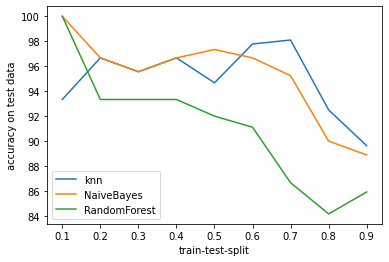

In [68]:
plt.plot(param,KNN_acc, label='knn')
plt.plot(param,NaiveBayes_acc, label='NaiveBayes')
plt.plot(param,RandomForest_acc, label='RandomForest')
plt.xlabel("train-test-split")
plt.ylabel("accuracy on test data")
plt.legend()